# Anime Recommender

*Recommending similar anime using KNN and K-Means*


CSE445 Course Project and my first Machine Learning Project.

# Data Preprocessing

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import time
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [3]:
#source dataset path
path1 = r'D:\NSU\11th Semester\CSE445 - AZK\Project\Anime.csv'
path2 = r'D:\NSU\11th Semester\CSE445 - AZK\Project\profiles.csv'

In [4]:
#reading csv file
anime_data = pd.read_csv(path1)
anime_data.head()

,animeID,name,title_english,type,source,producers,genre,studio,episodes,score,scored_by,popularity,members,favorites,synopsis,premiered,related
0,1,Cowboy Bebop,Cowboy Bebop,TV,Original,['Bandai Visual'],"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",['Sunrise'],26.0,8.81,405664.0,39.0,795733.0,43460.0,"In the year 2071, humanity has colonized sever...",Spring 1998,"{'Adaptation': [{'mal_id': 173, 'type': 'manga..."
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,Movie,Original,"['Sunrise', 'Bandai Visual']","['Action', 'Drama', 'Mystery', 'Sci-Fi', 'Space']",['Bones'],1.0,8.41,120243.0,449.0,197791.0,776.0,"Another day, another bounty—such is the life o...",NaN,"{'Parent story': [{'mal_id': 1, 'type': 'anime..."
2,6,Trigun,Trigun,TV,Manga,['Victor Entertainment'],"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...",['Madhouse'],26.0,8.30,212537.0,146.0,408548.0,10432.0,"Vash the Stampede is the man with a $$60,000,0...",Spring 1998,"{'Adaptation': [{'mal_id': 703, 'type': 'manga..."
3,7,Witch Hunter Robin,Witch Hunter Robin,TV,Original,['Bandai Visual'],"['Action', 'Magic', 'Police', 'Supernatural', ...",['Sunrise'],26.0,7.33,32837.0,1171.0,79397.0,537.0,Witches are individuals with special powers li...,Summer 2002,{}
4,8,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"['TV Tokyo', 'Dentsu']","['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",['Toei Animation'],52.0,7.03,4894.0,3704.0,11708.0,14.0,It is the dark century and the people are suff...,Fall 2004,"{'Adaptation': [{'mal_id': 1348, 'type': 'mang..."


# Preparing Data

In [5]:
anime_data.columns

Index(['animeID', 'name', 'title_english', 'type', 'source', 'producers',
       'genre', 'studio', 'episodes', 'score', 'scored_by', 'popularity',
       'members', 'favorites', 'synopsis', 'premiered', 'related'],
      dtype='object')

In [6]:
#removing unnecessary Columns
del anime_data['producers']
del anime_data['studio']
del anime_data['popularity']
del anime_data['members']
del anime_data['favorites']
del anime_data['synopsis']
del anime_data['premiered']
del anime_data['related']

In [7]:
anime_data.head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by
0,1,Cowboy Bebop,Cowboy Bebop,TV,Original,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",26.0,8.81,405664.0
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,Movie,Original,"['Action', 'Drama', 'Mystery', 'Sci-Fi', 'Space']",1.0,8.41,120243.0
2,6,Trigun,Trigun,TV,Manga,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...",26.0,8.30,212537.0
3,7,Witch Hunter Robin,Witch Hunter Robin,TV,Original,"['Action', 'Magic', 'Police', 'Supernatural', ...",26.0,7.33,32837.0
4,8,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",52.0,7.03,4894.0


In [8]:
#removing completely blank cell
anime_data = anime_data[anime_data.name != '404']

In [9]:
#removing [,] and ' from genre
temp1 = anime_data['genre']

temp1 = temp1.str.replace('[','',regex=True)
temp1 = temp1.str.replace(']','',regex=True)
temp1 = temp1.str.replace("'",'',regex=True)

#updating genre
anime_data['genre'] = temp1
anime_data.head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by
0,1,Cowboy Bebop,Cowboy Bebop,TV,Original,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26.0,8.81,405664.0
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,Movie,Original,"Action, Drama, Mystery, Sci-Fi, Space",1.0,8.41,120243.0
2,6,Trigun,Trigun,TV,Manga,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26.0,8.30,212537.0
3,7,Witch Hunter Robin,Witch Hunter Robin,TV,Original,"Action, Magic, Police, Supernatural, Drama, My...",26.0,7.33,32837.0
4,8,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"Adventure, Fantasy, Shounen, Supernatural",52.0,7.03,4894.0


In [10]:
#checking if there is any unknown cell in type
anime_data[anime_data['type']=='Unknown'].head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by
8859,24023,Project758,NaN,Unknown,Unknown,Drama,NaN,NaN,0.0
9611,28613,Ginga Jinpuu Jinraiger,Galaxy Divine Wind Jinraiger,Unknown,Original,"Action, Adventure, Mecha",NaN,NaN,0.0
10339,30448,Mirai Arise,NaN,Unknown,Original,Sci-Fi,NaN,NaN,0.0
10344,30455,Kantai Collection: KanColle Zoku-hen,NaN,Unknown,Card game,"Action, Military, Sci-Fi, Slice of Life, School",NaN,NaN,0.0
11167,32455,Gekidol,NaN,Unknown,Unknown,Music,NaN,NaN,1.0


In [11]:
#removed unknown type animesource
anime_data = anime_data[anime_data.type != 'Unknown']

In [12]:
#checking if there is any unknown cell in source
anime_data[anime_data['source']=='Unknown'].head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by
60,88,Mobile Suit Gundam F91,Mobile Suit Gundam F91,Movie,Unknown,"Drama, Mecha, Military, Sci-Fi, Space",1.0,6.78,9833.0
78,108,Ou Dorobou Jing in Seventh Heaven,Jing: King of Bandits - Seventh Heaven,OVA,Unknown,"Adventure, Fantasy, Psychological, Comedy, Sho...",3.0,7.37,4665.0
140,176,Triangle Heart: Sweet Songs Forever,NaN,OVA,Unknown,"Adventure, Romance",4.0,6.24,2182.0
153,192,Love Hina Haru Special: Kimi Sakura Chiru Naka...,Love Hina Spring Movie,Special,Unknown,"Adventure, Comedy, Romance",1.0,7.27,27974.0
155,194,Macross Zero,Macross Zero,OVA,Unknown,"Adventure, Mecha, Military, Sci-Fi, Shounen",5.0,7.62,15264.0


In [13]:
#assuming unknow sources are original
anime_data.loc[anime_data['source']=='Unknown','source'] = 'Original'

In [14]:
#clearing cells with 0 scored by
anime_data.loc[anime_data['scored_by']==0,'scored_by'] = None
#anime_data[anime_data['scored_by']==0].head()

In [15]:
#checking all types for anime  
anime_data.type.unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music'], dtype=object)

In [16]:
#finding median of tv series episodes
tv = anime_data[anime_data['type'] == 'TV']
tv_median = tv['episodes'].median(skipna=True)
tv_median

24.0

In [17]:
#filling tv episodes null value with median
tv['episodes'].fillna(tv_median, inplace = True)

D:\Programs\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [18]:
#finding average tv rating and average scored by
tv_rating_avg = tv['score'].mean(skipna=True)
tv_scoredBy_avg = math.floor(tv['scored_by'].mean(skipna=True))

#filling empty tv rating and scored by with average
tv['score'].fillna(tv_rating_avg, inplace = True)
tv['scored_by'].fillna(tv_scoredBy_avg, inplace = True)

In [19]:
#merging these values in main anime_data
anime_data.update(tv)

In [20]:
#not needed anymore
#replacing any unknown cell in episode with 1
#anime_data['episodes'].fillna(1, inplace = True)
#anime_data[anime_data['episodes']==1].head()


In [21]:
tv.head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by
0,1,Cowboy Bebop,Cowboy Bebop,TV,Original,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26.0,8.81,405664.0
2,6,Trigun,Trigun,TV,Manga,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26.0,8.30,212537.0
3,7,Witch Hunter Robin,Witch Hunter Robin,TV,Original,"Action, Magic, Police, Supernatural, Drama, My...",26.0,7.33,32837.0
4,8,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"Adventure, Fantasy, Shounen, Supernatural",52.0,7.03,4894.0
5,16,Hachimitsu to Clover,Honey and Clover,TV,Manga,"Comedy, Drama, Josei, Romance, Slice of Life",24.0,8.12,57065.0


In [22]:
#Movies have 1 episode
movie = anime_data[anime_data['type'] == 'Movie']

#filling Movies episode null value with 1
movie['episodes'].fillna(1, inplace = True)

#finding average movie rating and average scored by
movie_rating_avg = movie['score'].mean(skipna=True)
movie_scoredBy_avg = math.floor(movie['scored_by'].mean(skipna=True))

#filling empty movie rating and scored by with average
movie['score'].fillna(movie_rating_avg, inplace = True)
movie['scored_by'].fillna(movie_scoredBy_avg, inplace = True)

#merging these values in main anime_data
anime_data.update(movie)

In [23]:
#finding median of OVA  episodes
ova = anime_data[anime_data['type'] == 'OVA']
ova_median = ova['episodes'].median(skipna=True)

#filling OVA episodes null value with median
ova['episodes'].fillna(ova_median, inplace = True)

#finding average OVA rating and average scored by
ova_rating_avg = ova['score'].mean(skipna=True)
ova_scoredBy_avg = math.floor(ova['scored_by'].mean(skipna=True))

#filling empty OVA rating and scored by with average
ova['score'].fillna(ova_rating_avg, inplace = True)
ova['scored_by'].fillna(ova_scoredBy_avg, inplace = True)

#merging these values in main anime_data
anime_data.update(ova)

In [24]:
#finding median of Special episodes
special = anime_data[anime_data['type'] == 'Special']
special_median = special['episodes'].median(skipna=True)

#filling Special episodes null value with median
special['episodes'].fillna(special_median, inplace = True)

#finding average Special rating and average scored by
special_rating_avg = special['score'].mean(skipna=True)
special_scoredBy_avg = math.floor(special['scored_by'].mean(skipna=True))

#filling empty Special rating and scored by with average
special['score'].fillna(special_rating_avg, inplace = True)
special['scored_by'].fillna(special_scoredBy_avg, inplace = True)

#merging these values in main anime_data
anime_data.update(special)

In [25]:
#finding median of ONA  episodes
ona = anime_data[anime_data['type'] == 'ONA']
ona_median = ona['episodes'].median(skipna=True)

#filling ONA null value with median
ona['episodes'].fillna(ona_median, inplace = True)

#finding average ONA rating and average scored by
ona_rating_avg = ona['score'].mean(skipna=True)
ona_scoredBy_avg = math.floor(ona['scored_by'].mean(skipna=True))

#filling empty ONA rating and scored by with average
ona['score'].fillna(ona_rating_avg, inplace = True)
ona['scored_by'].fillna(ona_scoredBy_avg, inplace = True)

#mergin these values in main anime_data
anime_data.update(ona)

In [26]:
#finding median of Music  episodes
music = anime_data[anime_data['type'] == 'Music']
music_median = ova['episodes'].median(skipna=True)

#filling Music null value with median
music['episodes'].fillna(music_median, inplace = True)

#finding average Music rating and average scored by
music_rating_avg = music['score'].mean(skipna=True)
music_scoredBy_avg = math.floor(music['scored_by'].mean(skipna=True))

#filling empty Music rating and scored by with average
music['score'].fillna(music_rating_avg, inplace = True)
music['scored_by'].fillna(music_scoredBy_avg, inplace = True)

#mergin these values in main anime_data
anime_data.update(music)

In [27]:
#checking if a Unknown values are replaced
episode = anime_data['episodes']
episode[15135]

2.0

In [28]:
#nan_rows = anime_data[anime_data.isnull().any(1)]
#nan_rows.head(50)
#anime_data.isnull().sum()

finding weighted rating

In [29]:
#finding mean rating across the whole anime_data
mean_animeRating = anime_data['score'].mean()

In [30]:
#funtion to find weighted reating
def W_R(a, C=mean_animeRating):
    v = a['scored_by']
    R = a['score']
    return (v/(v+1) * R) + (1/(1+v) * C)

In [31]:
#new column with weighted rating
anime_data['rating'] = anime_data.apply(W_R, axis=1)
#anime_data.head()

In [32]:
#anime_data.to_csv(r'D:\NSU\11th Semester\CSE445 - AZK\Project\test1.csv', index=False, mode= 'w')

In [33]:
anime_data.head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by,rating
0,1.0,Cowboy Bebop,Cowboy Bebop,TV,Original,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26.0,8.81,405664.0,8.809994
1,5.0,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,Movie,Original,"Action, Drama, Mystery, Sci-Fi, Space",1.0,8.41,120243.0,8.409982
2,6.0,Trigun,Trigun,TV,Manga,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26.0,8.30,212537.0,8.299991
3,7.0,Witch Hunter Robin,Witch Hunter Robin,TV,Original,"Action, Magic, Police, Supernatural, Drama, My...",26.0,7.33,32837.0,7.329968
4,8.0,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"Adventure, Fantasy, Shounen, Supernatural",52.0,7.03,4894.0,7.029848


User Data file

In [34]:
#reading user data csv
user_data = pd.read_csv(path2)

In [35]:
user_data.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,02-Oct-94,"['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,10-Nov-00,"['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep-05,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,30-Oct-99,"['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


In [36]:
#replacing empty cells as unknown gender
user_data['gender'].fillna('unknown', inplace = True)
user_data.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,02-Oct-94,"['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,10-Nov-00,"['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,unknown,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep-05,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,30-Oct-99,"['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


In [37]:
#removed unknown type gender
user_data = user_data[user_data.gender != 'unknown']

In [38]:
len(user_data)

53856

In [39]:
#replacing [,] and ' from the favourites anime
temp = user_data['favorites_anime']

temp = temp.str.replace('[','',regex=True)
temp = temp.str.replace(']','',regex=True)
temp = temp.str.replace("'",'',regex=True)
temp.head()

0    33352, 25013, 5530, 33674, 1482, 269, 18245, 2...
1    11061, 31964, 853, 20583, 918, 9253, 34599, 35...
3                         5680, 849, 2904, 3588, 37349
4    4181, 7791, 9617, 5680, 2167, 4382, 849, 235, ...
7    11061, 30, 6594, 28701, 10087, 6746, 918, 1535...
Name: favorites_anime, dtype: object

In [40]:
#updating favourites anime
user_data['favorites_anime'] = temp
user_data.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,02-Oct-94,"33352, 25013, 5530, 33674, 1482, 269, 18245, 2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,10-Nov-00,"11061, 31964, 853, 20583, 918, 9253, 34599, 35...",https://myanimelist.net/profile/baekbeans
3,edgewalker00,Male,Sep-05,"5680, 849, 2904, 3588, 37349",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,30-Oct-99,"4181, 7791, 9617, 5680, 2167, 4382, 849, 235, ...",https://myanimelist.net/profile/aManOfCulture99
7,NIGGER_BONER,Male,01-Jan-85,"11061, 30, 6594, 28701, 10087, 6746, 918, 1535...",https://myanimelist.net/profile/NIGGER_BONER


In [41]:
#separating favourite anime genderwise
male_fav=user_data[user_data['gender']=='Male']
female_fav=user_data[user_data['gender']=='Female']
#male_fav.head()

In [42]:
#counting female fans of anime id wise
f_data = female_fav.favorites_anime.str.get_dummies(sep=', ').sum()

In [43]:
f_data

1        597
100       27
1000       6
10012     12
10015      4
        ... 
9981       3
9982       5
9989     333
9996       2
9999       2
Length: 2633, dtype: int64

In [44]:
#counting male fans of anime id wise
m_data = male_fav.favorites_anime.str.get_dummies(sep=', ').sum()

In [45]:
#creating a dataframe with anime id and female fan number
temp_1 = pd.DataFrame({'animeID': f_data.index, 'female_fan': f_data})
#df = pd.DataFrame({'female_fan': f_data})
temp_1.reset_index(drop=True, inplace=True)
temp_1.head()

,animeID,female_fan
0,1,597
1,100,27
2,1000,6
3,10012,12
4,10015,4


In [46]:
#creating another dataframe with anime id and male fan number
temp_2 = pd.DataFrame({'animeID': m_data.index, 'male_fan': m_data})
temp_2.reset_index(drop=True, inplace=True)
temp_2.head()

,animeID,male_fan
0,1,2922
1,100,1
2,1000,23
3,10012,67
4,10015,2


In [47]:
#merging two dataframe based on anime id
#temp_3 =  pd.DataFrame.merge(temp_2,temp_1,on='animeID')
temp_3 = temp_2.merge(temp_1,how='left', left_on='animeID', right_on='animeID')
temp_3.head()

,animeID,male_fan,female_fan
0,1,2922,597.0
1,100,1,27.0
2,1000,23,6.0
3,10012,67,12.0
4,10015,2,4.0


In [48]:
#temp_3.to_csv(r'D:\NSU\11th Semester\CSE445 - AZK\Project\user_data.csv')

In [49]:
#converting anime id from str to numeric
temp_3["animeID"] = pd.to_numeric(temp_3["animeID"])

In [50]:
#creating a new dataframe combining anime data and user data
#df =  pd.DataFrame.merge(anime_data,temp_3,on='animeID')
df = anime_data.merge(temp_3,how='left', left_on='animeID', right_on='animeID')
df.head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by,rating,male_fan,female_fan
0,1.0,Cowboy Bebop,Cowboy Bebop,TV,Original,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26.0,8.81,405664.0,8.809994,2922.0,597.0
1,5.0,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,Movie,Original,"Action, Drama, Mystery, Sci-Fi, Space",1.0,8.41,120243.0,8.409982,36.0,11.0
2,6.0,Trigun,Trigun,TV,Manga,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26.0,8.30,212537.0,8.299991,609.0,179.0
3,7.0,Witch Hunter Robin,Witch Hunter Robin,TV,Original,"Action, Magic, Police, Supernatural, Drama, My...",26.0,7.33,32837.0,7.329968,18.0,24.0
4,8.0,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"Adventure, Fantasy, Shounen, Supernatural",52.0,7.03,4894.0,7.029848,NaN,NaN


In [51]:
#filling empty cells with 0
df['male_fan'].fillna(0, inplace=True)
df['female_fan'].fillna(0, inplace=True)

In [52]:
#funtion to calculate fanbase gender biasness
def Fan(a):
    x = a['male_fan']
    y = a['female_fan']
    return (x-y)

In [53]:
#new column with fan base
df['fan_base'] = df.apply(Fan, axis=1)

In [54]:
df.head()

,animeID,name,title_english,type,source,genre,episodes,score,scored_by,rating,male_fan,female_fan,fan_base
0,1.0,Cowboy Bebop,Cowboy Bebop,TV,Original,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26.0,8.81,405664.0,8.809994,2922.0,597.0,2325.0
1,5.0,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,Movie,Original,"Action, Drama, Mystery, Sci-Fi, Space",1.0,8.41,120243.0,8.409982,36.0,11.0,25.0
2,6.0,Trigun,Trigun,TV,Manga,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26.0,8.30,212537.0,8.299991,609.0,179.0,430.0
3,7.0,Witch Hunter Robin,Witch Hunter Robin,TV,Original,"Action, Magic, Police, Supernatural, Drama, My...",26.0,7.33,32837.0,7.329968,18.0,24.0,-6.0
4,8.0,Bouken Ou Beet,Beet the Vandel Buster,TV,Manga,"Adventure, Fantasy, Shounen, Supernatural",52.0,7.03,4894.0,7.029848,0.0,0.0,0.0


In [55]:
#saving dataframe to csv file
df.to_csv(r'D:\NSU\11th Semester\CSE445 - AZK\Project\anime_data.csv')

In [56]:
df = pd.read_csv(r'D:\NSU\11th Semester\CSE445 - AZK\Project\anime_data.csv')

In [57]:
#converting feature to categorical values
temp_type = pd.get_dummies(df['type'])
temp_source = pd.get_dummies(df['source'])
temp_genre = df['genre'].str.get_dummies(sep=', ')

#temp_type.head()

In [58]:
#taking the features into a dataframe
anime = pd.concat([temp_type,temp_source,temp_genre,df['episodes'],df['rating'],df['fan_base']], axis=1)

In [59]:
anime.head()

,Movie,Music,ONA,OVA,Special,TV,4-koma manga,Book,Card game,Digital manga,...,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,episodes,rating,fan_base
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,26.0,8.809994,2325.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,8.409982,25.0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,26.0,8.299991,430.0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,26.0,7.329968,-6.0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,52.0,7.029848,0.0


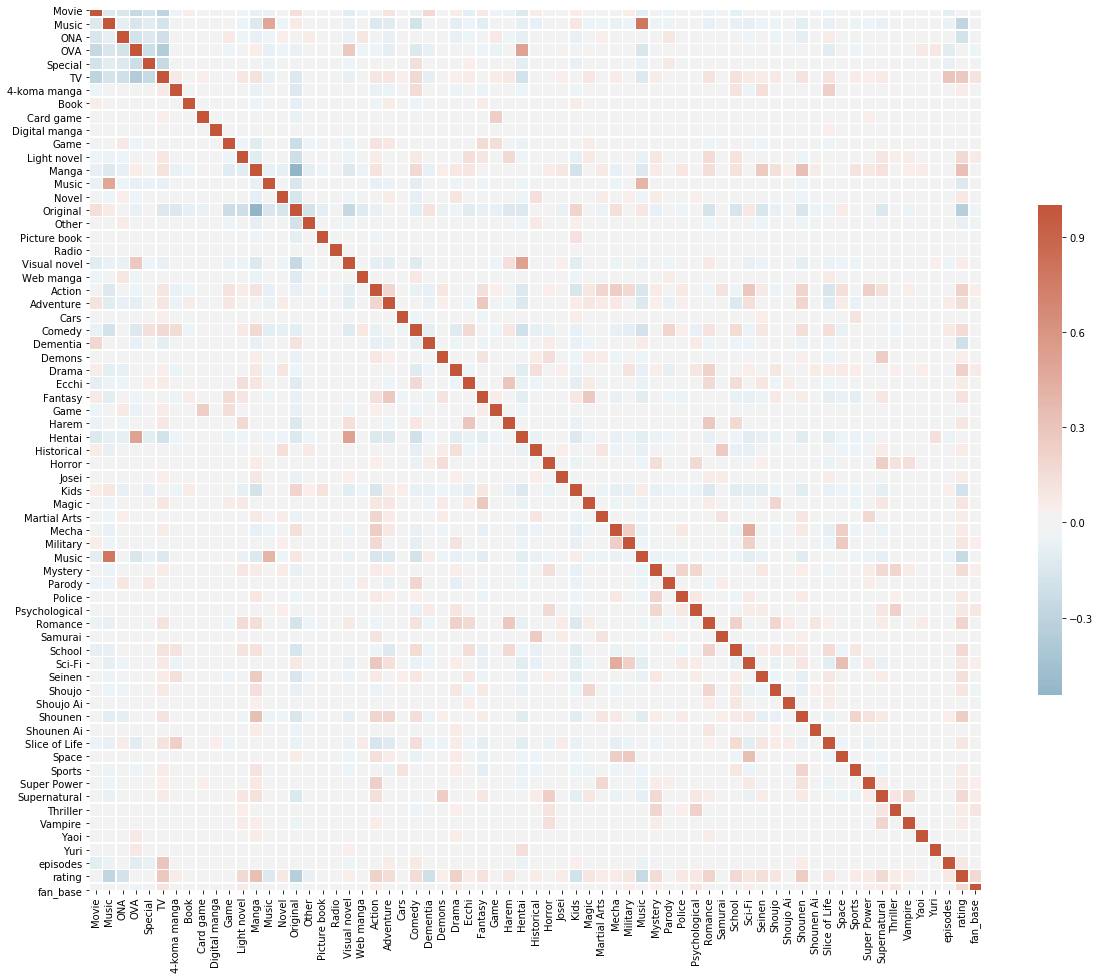

In [60]:
#correlation for features
# Compute the correlation matrix
corr = anime.corr()

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [61]:
#Scaling the values
scaler = MinMaxScaler()
anime = scaler.fit_transform(anime)
np.round(anime,2)

array([[0.  , 0.  , 0.  , ..., 0.01, 0.94, 0.58],
       [1.  , 0.  , 0.  , ..., 0.  , 0.89, 0.18],
       [0.  , 0.  , 0.  , ..., 0.01, 0.87, 0.25],
       ...,
       [0.  , 0.  , 1.  , ..., 0.  , 0.52, 0.17],
       [0.  , 0.  , 0.  , ..., 0.01, 0.66, 0.18],
       [0.  , 0.  , 0.  , ..., 0.01, 0.66, 0.17]])

# Unsupervised K Nearest Neighbors

In [62]:
#clustering using KNN
nbrs = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(anime)
distances, indices = nbrs.kneighbors(anime)

In [63]:
#funtion to get recommendation
def get_recommendation(name):
    rec_id=df.index[df['name']==name].tolist()[0]
    recommend = pd.DataFrame(columns = ['Recommended Anime', 'English Title', 'Type', 'Rating', 'Genre'])
    for id in indices[rec_id][1:]:
        new_row = {'Recommended Anime':df.iloc[id]['name'], 'English Title':df.iloc[id]['title_english'], 'Type':df.iloc[id]['type'], 'Rating':np.round(df.iloc[id]['rating'],2), 'Genre':df.iloc[id]['genre'] }
        recommend = recommend.append(new_row, ignore_index=True)
    print("Anime Recommendation for:", name, '/',df.iloc[rec_id]['title_english'])
    display(recommend)

### Getting Recommendation using KNN

In [64]:
get_recommendation('Cowboy Bebop')

Anime Recommendation for: Cowboy Bebop / Cowboy Bebop


,Recommended Anime,English Title,Type,Rating,Genre
0,Ginga Tetsudou Monogatari,The Galaxy Railways,TV,7.25,"Action, Adventure, Space, Drama, Sci-Fi"
1,Ginga Tetsudou Monogatari: Eien e no Bunkiten,NaN,TV,6.98,"Action, Adventure, Space, Drama, Sci-Fi"
2,Seihou Tenshi Angel Links,Angel Links,TV,6.02,"Action, Adventure, Space, Comedy, Romance, Dra..."
3,Uchuu Patrol Luluco,Space Patrol Luluco,TV,7.68,"Action, Adventure, Comedy, Space"
4,Uchuu Senkan Yamato,Star Blazers: The Quest for Iscandar,TV,7.67,"Action, Adventure, Drama, Military, Sci-Fi, Space"
5,Uchuu Senkan Yamato 2,Star Blazers: The Comet Empire,TV,7.55,"Action, Military, Sci-Fi, Adventure, Space, Drama"
6,Cowboy Bebop: Yose Atsume Blues,Cowboy Bebop Session XX,Special,7.49,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
7,Uchuu Senkan Yamato III,Star Blazers: The Bolar Wars,TV,7.21,"Action, Military, Sci-Fi, Adventure, Space, Drama"
8,Uchuu Densetsu Ulysses 31,Ulysses 31,TV,7.15,"Action, Adventure, Sci-Fi, Space"
9,Iron Kid,Eon Kid,TV,7.06,"Action, Adventure, Comedy, Sci-Fi"


# Checking other Nearest Neighbors search algorithms

## Brute algorithm

In [65]:
%%time
nbrs1 = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(anime)
distances1, indices1 = nbrs1.kneighbors(anime)

Wall time: 4.7 s


In [66]:
#funtion to get recommendation from brute
def get_recommendation_Brute(name):
    rec_id=df.index[df['name']==name].tolist()[0]
    recommend = pd.DataFrame(columns = ['Recommended Anime', 'English Title', 'Type', 'Rating', 'Genre'])
    for id in indices1[rec_id][:]:
        new_row = {'Recommended Anime':df.iloc[id]['name'], 'English Title':df.iloc[id]['title_english'], 'Type':df.iloc[id]['type'], 'Rating':np.round(df.iloc[id]['rating'],2), 'Genre':df.iloc[id]['genre'] }
        recommend = recommend.append(new_row, ignore_index=True)
    print("Anime Recommendation for:", name, '/',df.iloc[rec_id]['title_english'])
    display(recommend)

In [67]:
distances1

array([[0.        , 1.10067573, 1.1081936 , ..., 1.48265702, 1.48775968,
        1.4888789 ],
       [0.        , 1.41606606, 1.41810946, ..., 1.56845625, 1.73339718,
        1.73379833],
       [0.        , 1.02350008, 1.41505862, ..., 1.4188526 , 1.41959297,
        1.42004394],
       ...,
       [0.        , 0.01946333, 1.00000025, ..., 1.00009246, 1.00009917,
        1.00010261],
       [0.        , 1.0000399 , 1.00117049, ..., 1.41599442, 1.41618116,
        1.41685002],
       [0.        , 0.23137357, 1.00000025, ..., 1.41421672, 1.41422498,
        1.41423112]])

In [68]:
#printing distance matrixas dataframe for better visualization
pd.DataFrame(distances1)

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.100676,1.108194,1.144710,1.478284,1.479574,1.481531,1.482657,1.487760,1.488879
1,0.0,1.416066,1.418109,1.423655,1.426490,1.437977,1.481053,1.568456,1.733397,1.733798
2,0.0,1.023500,1.415059,1.416404,1.416719,1.417555,1.418584,1.418853,1.419593,1.420044
3,0.0,1.732064,1.734607,2.000047,2.000052,2.000136,2.000570,2.001120,2.001261,2.001281
4,0.0,0.033879,0.093164,0.112085,1.001799,1.002741,1.006064,1.016809,1.414255,1.414407
...,...,...,...,...,...,...,...,...,...,...
15233,0.0,1.414261,1.414820,1.414943,1.414990,1.416735,1.732052,1.732059,1.732070,1.732074
15234,0.0,1.000004,1.001782,1.022514,1.414214,1.418791,1.418971,1.419427,1.419665,1.420146
15235,0.0,0.019463,1.000000,1.000004,1.000006,1.000027,1.000047,1.000092,1.000099,1.000103
15236,0.0,1.000040,1.001170,1.002171,1.414255,1.414536,1.415354,1.415994,1.416181,1.416850


In [69]:
get_recommendation_Brute('Cowboy Bebop')

Anime Recommendation for: Cowboy Bebop / Cowboy Bebop


,Recommended Anime,English Title,Type,Rating,Genre
0,Cowboy Bebop,Cowboy Bebop,TV,8.81,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,Ginga Tetsudou Monogatari,The Galaxy Railways,TV,7.25,"Action, Adventure, Space, Drama, Sci-Fi"
2,Ginga Tetsudou Monogatari: Eien e no Bunkiten,NaN,TV,6.98,"Action, Adventure, Space, Drama, Sci-Fi"
3,Seihou Tenshi Angel Links,Angel Links,TV,6.02,"Action, Adventure, Space, Comedy, Romance, Dra..."
4,Uchuu Patrol Luluco,Space Patrol Luluco,TV,7.68,"Action, Adventure, Comedy, Space"
5,Uchuu Senkan Yamato,Star Blazers: The Quest for Iscandar,TV,7.67,"Action, Adventure, Drama, Military, Sci-Fi, Space"
6,Uchuu Senkan Yamato 2,Star Blazers: The Comet Empire,TV,7.55,"Action, Military, Sci-Fi, Adventure, Space, Drama"
7,Cowboy Bebop: Yose Atsume Blues,Cowboy Bebop Session XX,Special,7.49,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
8,Uchuu Senkan Yamato III,Star Blazers: The Bolar Wars,TV,7.21,"Action, Military, Sci-Fi, Adventure, Space, Drama"
9,Uchuu Densetsu Ulysses 31,Ulysses 31,TV,7.15,"Action, Adventure, Sci-Fi, Space"


## BallTree Algorithm

In [70]:
%%time
nbrs2 = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(anime)
distances2, indices2 = nbrs2.kneighbors(anime)

Wall time: 19.1 s


In [71]:
#funtion to get recommendation from BallTree
def get_recommendation_BallTree(name):
    rec_id=df.index[df['name']==name].tolist()[0]
    recommend = pd.DataFrame(columns = ['Recommended Anime', 'English Title', 'Type', 'Rating', 'Genre'])
    for id in indices2[rec_id][:]:
        new_row = {'Recommended Anime':df.iloc[id]['name'], 'English Title':df.iloc[id]['title_english'], 'Type':df.iloc[id]['type'], 'Rating':np.round(df.iloc[id]['rating'],2), 'Genre':df.iloc[id]['genre'] }
        recommend = recommend.append(new_row, ignore_index=True)
    print("Anime Recommendation for:", name, '/',df.iloc[rec_id]['title_english'])
    display(recommend)

In [72]:
distances2

array([[0.        , 1.10067573, 1.1081936 , ..., 1.48265702, 1.48775968,
        1.4888789 ],
       [0.        , 1.41606606, 1.41810946, ..., 1.56845625, 1.73339718,
        1.73379833],
       [0.        , 1.02350008, 1.41505862, ..., 1.4188526 , 1.41959297,
        1.42004394],
       ...,
       [0.        , 0.01946333, 1.00000025, ..., 1.00009246, 1.00009917,
        1.00010261],
       [0.        , 1.0000399 , 1.00117049, ..., 1.41599442, 1.41618116,
        1.41685002],
       [0.        , 0.23137357, 1.00000025, ..., 1.41421672, 1.41422498,
        1.41423112]])

In [73]:
#printing distance matrixas dataframe for better visualization
pd.DataFrame(distances1)

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.100676,1.108194,1.144710,1.478284,1.479574,1.481531,1.482657,1.487760,1.488879
1,0.0,1.416066,1.418109,1.423655,1.426490,1.437977,1.481053,1.568456,1.733397,1.733798
2,0.0,1.023500,1.415059,1.416404,1.416719,1.417555,1.418584,1.418853,1.419593,1.420044
3,0.0,1.732064,1.734607,2.000047,2.000052,2.000136,2.000570,2.001120,2.001261,2.001281
4,0.0,0.033879,0.093164,0.112085,1.001799,1.002741,1.006064,1.016809,1.414255,1.414407
...,...,...,...,...,...,...,...,...,...,...
15233,0.0,1.414261,1.414820,1.414943,1.414990,1.416735,1.732052,1.732059,1.732070,1.732074
15234,0.0,1.000004,1.001782,1.022514,1.414214,1.418791,1.418971,1.419427,1.419665,1.420146
15235,0.0,0.019463,1.000000,1.000004,1.000006,1.000027,1.000047,1.000092,1.000099,1.000103
15236,0.0,1.000040,1.001170,1.002171,1.414255,1.414536,1.415354,1.415994,1.416181,1.416850


In [74]:
get_recommendation_BallTree('Cowboy Bebop')

Anime Recommendation for: Cowboy Bebop / Cowboy Bebop


,Recommended Anime,English Title,Type,Rating,Genre
0,Cowboy Bebop,Cowboy Bebop,TV,8.81,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,Ginga Tetsudou Monogatari,The Galaxy Railways,TV,7.25,"Action, Adventure, Space, Drama, Sci-Fi"
2,Ginga Tetsudou Monogatari: Eien e no Bunkiten,NaN,TV,6.98,"Action, Adventure, Space, Drama, Sci-Fi"
3,Seihou Tenshi Angel Links,Angel Links,TV,6.02,"Action, Adventure, Space, Comedy, Romance, Dra..."
4,Uchuu Patrol Luluco,Space Patrol Luluco,TV,7.68,"Action, Adventure, Comedy, Space"
5,Uchuu Senkan Yamato,Star Blazers: The Quest for Iscandar,TV,7.67,"Action, Adventure, Drama, Military, Sci-Fi, Space"
6,Uchuu Senkan Yamato 2,Star Blazers: The Comet Empire,TV,7.55,"Action, Military, Sci-Fi, Adventure, Space, Drama"
7,Cowboy Bebop: Yose Atsume Blues,Cowboy Bebop Session XX,Special,7.49,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
8,Uchuu Senkan Yamato III,Star Blazers: The Bolar Wars,TV,7.21,"Action, Military, Sci-Fi, Adventure, Space, Drama"
9,Uchuu Densetsu Ulysses 31,Ulysses 31,TV,7.15,"Action, Adventure, Sci-Fi, Space"


## KDTree Algorithm

In [75]:
%%time
nbrs3 = NearestNeighbors(n_neighbors=10, algorithm='kd_tree').fit(anime)
distances3, indices3 = nbrs3.kneighbors(anime)

Wall time: 14.6 s


In [76]:
#funtion to get recommendation from KDTree
def get_recommendation_KDTree(name):
    rec_id=df.index[df['name']==name].tolist()[0]
    recommend = pd.DataFrame(columns = ['Recommended Anime', 'English Title', 'Type', 'Rating', 'Genre'])
    for id in indices3[rec_id][:]:
        new_row = {'Recommended Anime':df.iloc[id]['name'], 'English Title':df.iloc[id]['title_english'], 'Type':df.iloc[id]['type'], 'Rating':np.round(df.iloc[id]['rating'],2), 'Genre':df.iloc[id]['genre'] }
        recommend = recommend.append(new_row, ignore_index=True)
    print("Anime Recommendation for:", name, '/',df.iloc[rec_id]['title_english'])
    display(recommend)

In [77]:
distances3

array([[0.        , 1.10067573, 1.1081936 , ..., 1.48265702, 1.48775968,
        1.4888789 ],
       [0.        , 1.41606606, 1.41810946, ..., 1.56845625, 1.73339718,
        1.73379833],
       [0.        , 1.02350008, 1.41505862, ..., 1.4188526 , 1.41959297,
        1.42004394],
       ...,
       [0.        , 0.01946333, 1.00000025, ..., 1.00009246, 1.00009917,
        1.00010261],
       [0.        , 1.0000399 , 1.00117049, ..., 1.41599442, 1.41618116,
        1.41685002],
       [0.        , 0.23137357, 1.00000025, ..., 1.41421672, 1.41422498,
        1.41423112]])

In [78]:
#printing distance matrixas dataframe for better visualization
pd.DataFrame(distances1)

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.100676,1.108194,1.144710,1.478284,1.479574,1.481531,1.482657,1.487760,1.488879
1,0.0,1.416066,1.418109,1.423655,1.426490,1.437977,1.481053,1.568456,1.733397,1.733798
2,0.0,1.023500,1.415059,1.416404,1.416719,1.417555,1.418584,1.418853,1.419593,1.420044
3,0.0,1.732064,1.734607,2.000047,2.000052,2.000136,2.000570,2.001120,2.001261,2.001281
4,0.0,0.033879,0.093164,0.112085,1.001799,1.002741,1.006064,1.016809,1.414255,1.414407
...,...,...,...,...,...,...,...,...,...,...
15233,0.0,1.414261,1.414820,1.414943,1.414990,1.416735,1.732052,1.732059,1.732070,1.732074
15234,0.0,1.000004,1.001782,1.022514,1.414214,1.418791,1.418971,1.419427,1.419665,1.420146
15235,0.0,0.019463,1.000000,1.000004,1.000006,1.000027,1.000047,1.000092,1.000099,1.000103
15236,0.0,1.000040,1.001170,1.002171,1.414255,1.414536,1.415354,1.415994,1.416181,1.416850


In [79]:
get_recommendation_KDTree('Cowboy Bebop')

Anime Recommendation for: Cowboy Bebop / Cowboy Bebop


,Recommended Anime,English Title,Type,Rating,Genre
0,Cowboy Bebop,Cowboy Bebop,TV,8.81,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,Ginga Tetsudou Monogatari,The Galaxy Railways,TV,7.25,"Action, Adventure, Space, Drama, Sci-Fi"
2,Ginga Tetsudou Monogatari: Eien e no Bunkiten,NaN,TV,6.98,"Action, Adventure, Space, Drama, Sci-Fi"
3,Seihou Tenshi Angel Links,Angel Links,TV,6.02,"Action, Adventure, Space, Comedy, Romance, Dra..."
4,Uchuu Patrol Luluco,Space Patrol Luluco,TV,7.68,"Action, Adventure, Comedy, Space"
5,Uchuu Senkan Yamato,Star Blazers: The Quest for Iscandar,TV,7.67,"Action, Adventure, Drama, Military, Sci-Fi, Space"
6,Uchuu Senkan Yamato 2,Star Blazers: The Comet Empire,TV,7.55,"Action, Military, Sci-Fi, Adventure, Space, Drama"
7,Cowboy Bebop: Yose Atsume Blues,Cowboy Bebop Session XX,Special,7.49,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
8,Uchuu Senkan Yamato III,Star Blazers: The Bolar Wars,TV,7.21,"Action, Military, Sci-Fi, Adventure, Space, Drama"
9,Uchuu Densetsu Ulysses 31,Ulysses 31,TV,7.15,"Action, Adventure, Sci-Fi, Space"


# Unsupervised K-means

## Checking different score to determine the cluster quality for different K

In [80]:
SSE = [] #for inertia
kmeSscore = [] #for Silhouette Coefficient
kmeanCHscore = [] #for Calinski-Harabasz Index
kmeanDBscore = [] #for Davies-Bouldin

In [93]:
%%time
for cluster in range(10,51,2):
    clear_output(wait=True)
    kmeans1 = KMeans(n_clusters = cluster, init='k-means++')
    kmeans1.fit(anime)
    SSE.append(kmeans1.inertia_)
    kmeSscore.append(metrics.silhouette_score(anime,kmeans1.labels_, metric='euclidean'))
    kmeanCHscore.append(metrics.calinski_harabasz_score(anime, kmeans1.labels_))
    kmeanDBscore.append(davies_bouldin_score(anime, kmeans1.labels_))
    print("Current Progress:",np.round(cluster/50 *100, 2),"%")

Current Progress: 100.0 %
Wall time: 2min 41s


### Inertia vs Cluster Graph

Text(0, 0.5, 'Inertia')

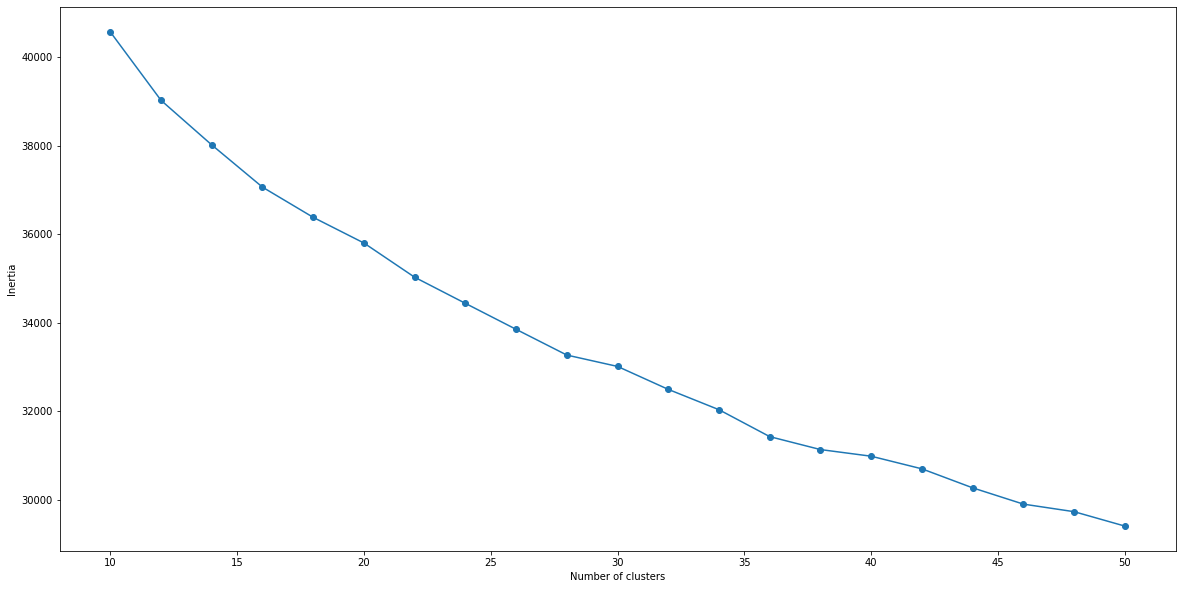

In [82]:
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(10,51,2), 'SSE':SSE})
plt.figure(figsize=(20,10))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [83]:
#combining evaluation scores in a dataframe
clu = range(10,51,2)
dict1 = { 'Cluster Number': clu, 'Inertia': SSE, 'Silhouette Coefficient': kmeSscore, 'Calinski-Harabasz Index': kmeanCHscore, 'Davies-Bouldin': kmeanDBscore}
score = pd.DataFrame(dict1)
score.to_csv(r'D:\NSU\11th Semester\CSE445 - AZK\Project\score.csv', index=False, mode='w')

### Inertia

Lowers values is better

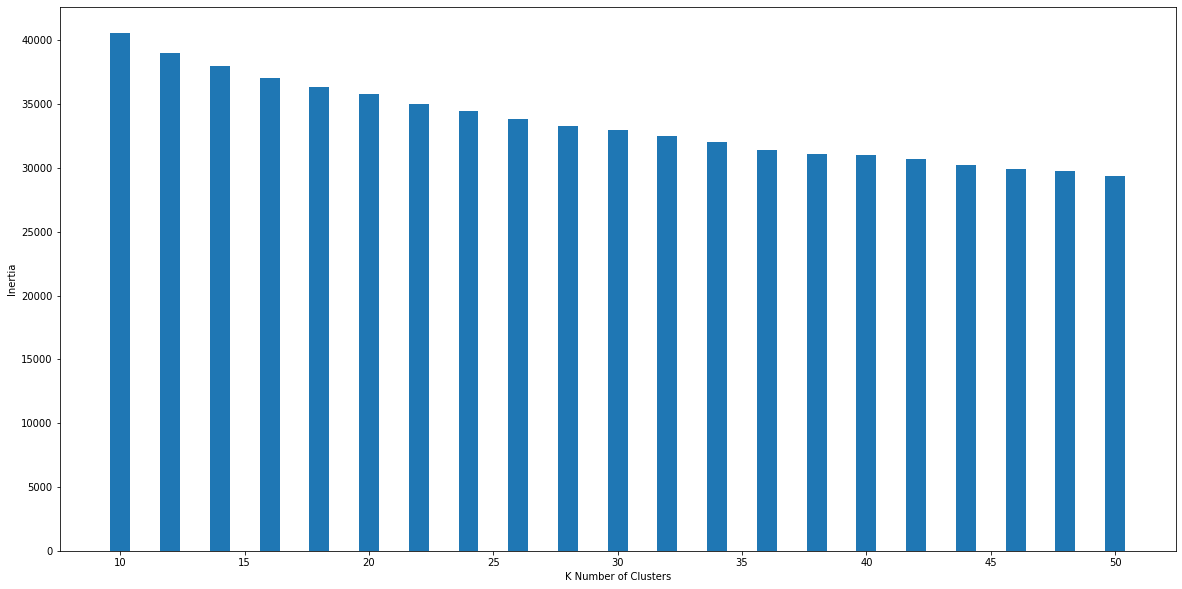

In [84]:
fig = plt.figure(figsize = (20, 10))

# creating the bar plot 
plt.bar(score['Cluster Number'],score['Inertia']) 

plt.xlabel("K Number of Clusters") 
plt.ylabel("Inertia") 
plt.show()

### Silhouette Coefficient
-1 to 1 | Higher value is better

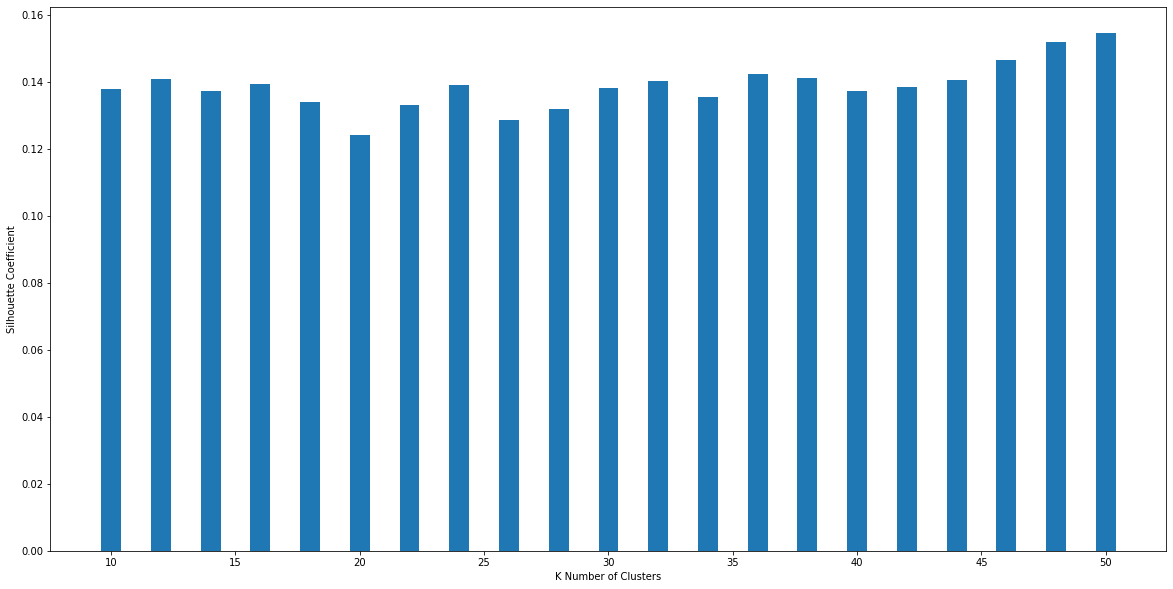

In [85]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score['Cluster Number'],score['Silhouette Coefficient']) 
  
plt.xlabel("K Number of Clusters") 
plt.ylabel("Silhouette Coefficient") 
plt.show()

### Calinski-Harabasz Index

Higher value is better

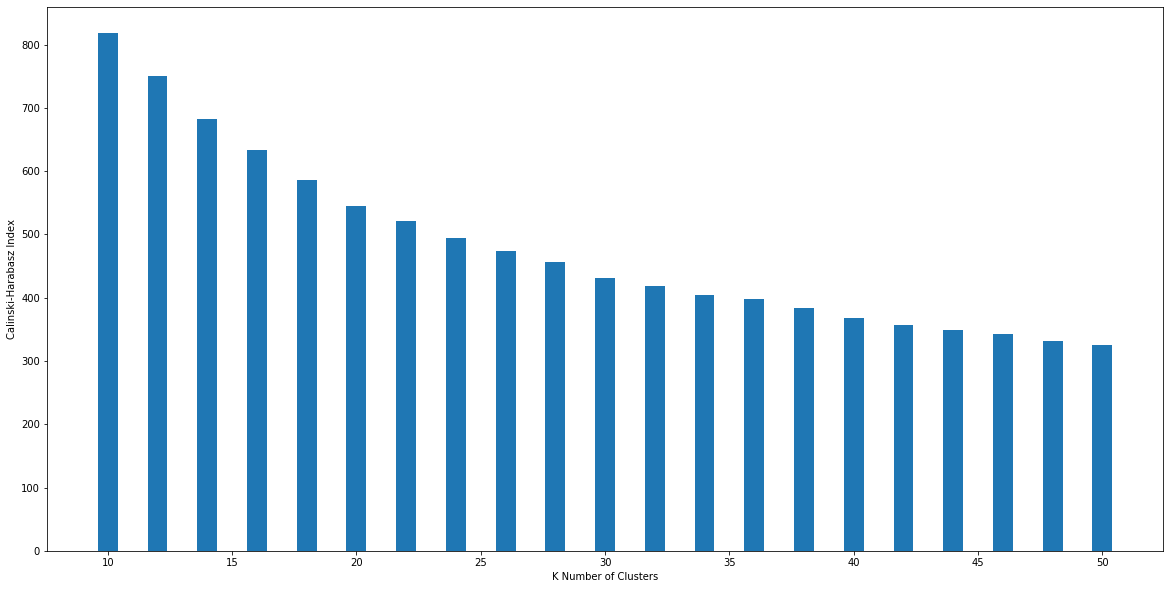

In [86]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score['Cluster Number'],score['Calinski-Harabasz Index']) 
  
plt.xlabel("K Number of Clusters") 
plt.ylabel("Calinski-Harabasz Index") 
plt.show()

### Davies-Bouldin Index

Lower value is better

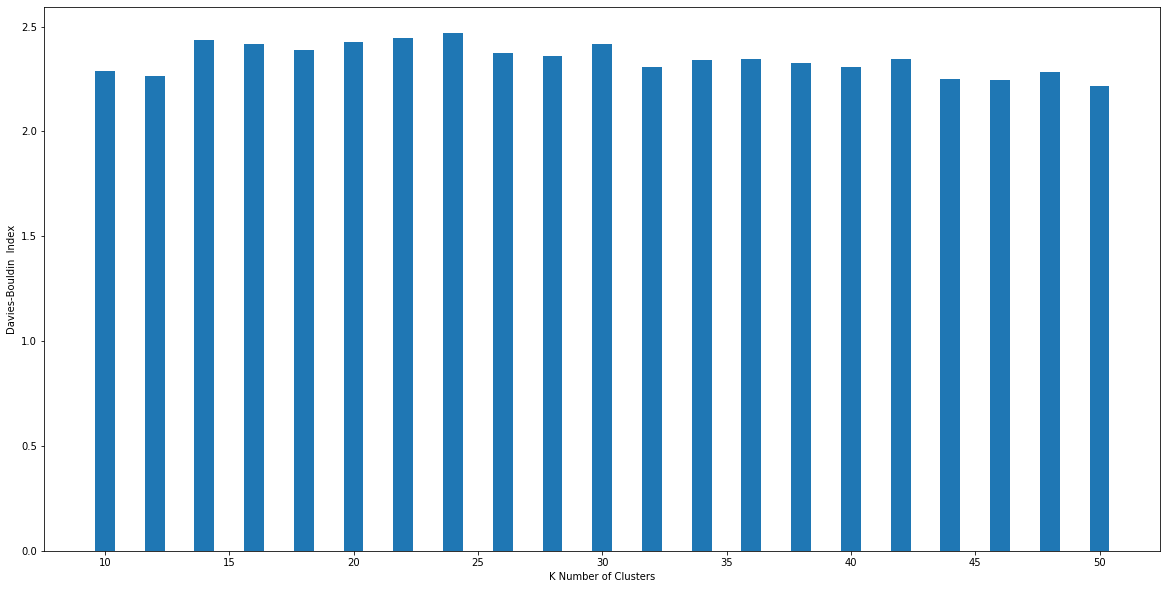

In [87]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score['Cluster Number'],score['Davies-Bouldin']) 
  
plt.xlabel("K Number of Clusters") 
plt.ylabel("Davies-Bouldin  Index") 
plt.show()

## Recommendation using K Means with k=42

In [88]:
%%time
kmeans = KMeans(n_clusters = 42, init='k-means++')
kmeans.fit(anime)

Wall time: 5.39 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=42, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [89]:
print('Inertia:', kmeans.inertia_ )
print('Silhouette Coefficent:',metrics.silhouette_score(anime,kmeans.labels_, metric='euclidean'))
print('Calinski Harabasz Index:',metrics.calinski_harabasz_score(anime, kmeans.labels_))
print('Davies Bouldin Index:',davies_bouldin_score(anime, kmeans.labels_))

Inertia: 30588.067305598615
Silhouette Coefficent: 0.14555913750633626
Calinski Harabasz Index: 358.8252411316751
Davies Bouldin Index: 2.2403835266604575


In [90]:
df1 = df
df1['label'] = kmeans.labels_

In [91]:
def get_recommendation_k(name):
    rec_id=df1.index[df1['name']==name].tolist()[0]
    rec_label = df1.iloc[rec_id]['label']
    df2=df1[df1['label'] == rec_label].head(10)
    print("Anime Recommendation for:", name, '/',df.iloc[rec_id]['title_english'])
    display(df2[['name','title_english','type','rating','genre']])

In [92]:
get_recommendation_k('Kimi no Na wa.')

Anime Recommendation for: Kimi no Na wa. / Your Name.


,name,title_english,type,rating,genre
254,Ace wo Nerae! (1979),Aim for the Ace! (1979),Movie,6.859385,"Sports, Drama, Romance, School, Shoujo"
343,Blood: The Last Vampire,Blood: The Last Vampire,Movie,6.969985,"Horror, Supernatural, Vampire"
375,Shoujo Kakumei Utena: Adolescence Mokushiroku,Revolutionary Girl Utena: The Adolescence of U...,Movie,7.599917,"Dementia, Drama, Fantasy, Romance, Shoujo, Sho..."
408,Hotori: Tada Saiwai wo Koinegau,NaN,Movie,7.049512,"Drama, Sci-Fi"
444,Marmalade Boy Movie,NaN,Movie,7.469631,"Romance, Shoujo"
615,Candy Candy (Movie),NaN,Movie,6.759582,"Slice of Life, Drama, Shoujo"
932,Kidou Keisatsu Patlabor the Movie,Patlabor: The Movie,Movie,7.559880,"Military, Police, Drama, Mecha"
1025,Nitaboh,NaN,Movie,7.469480,"Historical, Music"
1028,Ihatov Gensou: Kenji no Haru,Spring and Chaos,Movie,7.319390,"Drama, Historical, Slice of Life"
1277,Aru Machi Kado no Monogatari,Tales of the Street Corner,Movie,6.679634,"Drama, Music, Romance"
